# Odczyt i normalizacja danych emg.

In [110]:
import sys

sys.path.append("..")

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplot
from matplotlib.pyplot import figure
from IPython.display import set_matplotlib_formats

set_matplotlib_formats("svg")
mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False
plt.style.use("seaborn-ticks")
%matplotlib inline
from pyomeca import Analogs

from ezc3d import c3d

In [111]:
data_path = "../Jupyter/c3d/B0437 PrzenoszeniePrawidlowe T01.c3d"

#### Wczytanie danych analogowych i przydzielenie odpowiednich nazw

In [112]:
def read_analogs(data_path):
    muscles = [
    #"Force.Fx1",
    #"Force.Fy1",
    #"Force.Fz1",
    #"Moment.Mx1",
    #"Moment.My1",
    #"Moment.Mz1",
    #"Force.Fx2",
    #"Force.Fy2",
    #"Force.Fz2",
    #"Moment.Mx2",
    #"Moment.My2",
    #"Moment.Mz2",
    "Voltage.1",
    "Voltage.2",
    "Voltage.3",
    "Voltage.4",
    "Voltage.5",
    "Voltage.6",
    "Voltage.7",
    "Voltage.8",
    "Voltage.9",
    "Voltage.10",
    "Voltage.11",
    "Voltage.12",
    "Voltage.13",
    "Voltage.14",
    "Voltage.15",
    "Voltage.16"]
    
    emg = Analogs.from_c3d(data_path, usecols=muscles)
    
    muscles_names = [
    "Czworoboczny grzbietu L",
    "Trójgłowy ramienia L", 
    "Dwugłowy ramienia L", 
    "Prostownik nadgarstka L",
    "Skośny brzucha L", 
    "Pośladkowy średni L",
    "Czworogłowy uda L", 
    "Brzuchaty łydki L",
    "Czworoboczny grzbietu P",
    "Trójgłowy ramienia P", 
    "Dwugłowy ramienia P", 
    "Prostownik nadgarstka P",
    "Skośny brzucha P", 
    "Pośladkowy średni P",
    "Czworogłowy uda P", 
    "Brzuchaty łydki P"]
    
    emg['channel']=muscles_names
    return emg

#### Wyświetlanie danych na wykresie

In [113]:
def show_emg_data(data_to_show):
    data_to_show.plot(x="time", col="channel", col_wrap=3)

#### Normalizacja danych

In [114]:
def normalize_data(data_path):
    emg_p = (
        emg.meca.band_pass(order=2, cutoff=[10, 425])
        .meca.center()
        .meca.abs()
        .meca.low_pass(order=4, cutoff=5, freq=emg.rate)
        .meca.normalize(ref=None, scale=1)
    ) 
    emg_p.name = "EMG"
    emg_p.attrs["units"] = "%"
    emg_p.time.attrs["units"] = "seconds"
    return emg_p

#### Odczytanie oznaczonych event'ów z pliku

In [190]:
def read_events(data_path):
    c3d_to_compare= c3d(data_path)
    event = c3d_to_compare['parameters']['EVENT']['LABELS']['value']
    event_time = c3d_to_compare['parameters']['EVENT']['TIMES']['value'][1]
    n_frames = c3d_to_compare['parameters']['POINT']['FRAMES']['value'][0] 
    nn = n_frames/1000
    markevent = event_time/nn*100
    
    return [event, event_time]

## Wykresy danych z pliku .c3d (przed normalizacją):

In [116]:
readed_emg = read_analogs(data_path)
show_emg_data(readed_emg)

## Wykresy danych po normalizacji:

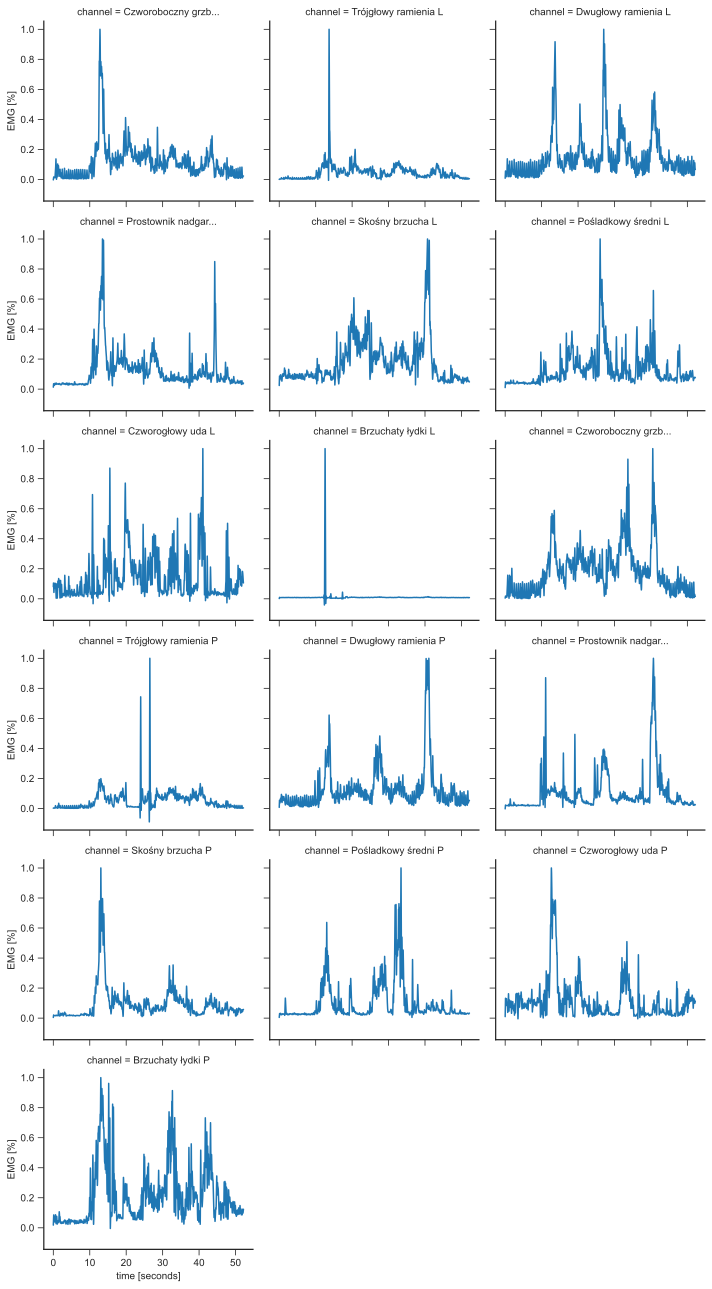

In [117]:
emg_processed = normalize_data(readed_emg)
show_emg_data(emg_processed)

## Odczytanie nazw event'ów:

In [191]:
read_events(data_path)

[['StartAction',
  'EndAction',
  'StartWyciagniecieDoPacjenta',
  'StartUgiecieNogPacjenta',
  'EndUgiecieNogPacjenta',
  'EndWyciagniecieDoPacjenta',
  'StartUlozeniePrawejRekiPacjenta',
  'EndUlozeniePrawejRekiPacjenta',
  'StartUlozenieLewejRekiPacjenta',
  'EndUlozenieLewejRekiPacjenta',
  'StartPrzewroceniePacjenta',
  'EndPrzewroceniePacjenta',
  'StartOpuszczenieNogPacjenta',
  'EndOpuszczenieNogPacjenta',
  'StartPosadzeniePacjenta',
  'EndPosadzeniePacjenta'],
 array([ 9.68000031, 44.63000107, 10.90999985, 12.26000023, 15.07999992,
        12.25      , 16.18000031, 19.12999916, 19.30999947, 24.03000069,
        24.88999939, 30.46999931, 31.13999939, 35.74000168, 37.15000153,
        43.52999878])]

## Event'y nałożone na przebieg pracy mięśni:

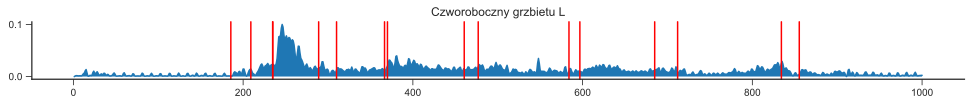

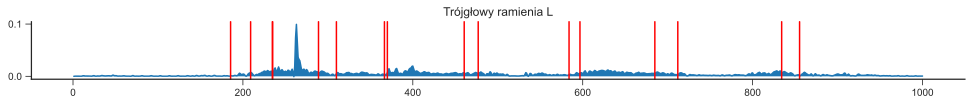

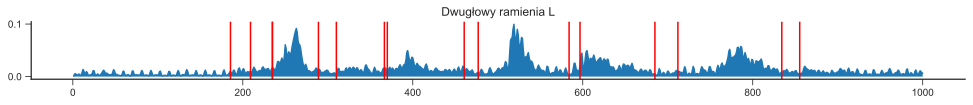

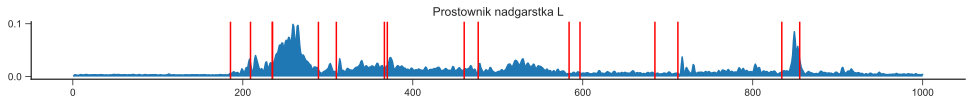

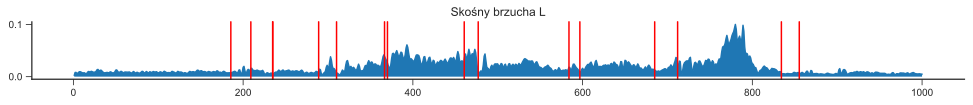

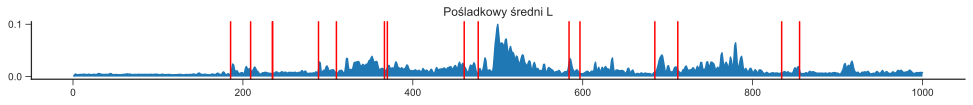

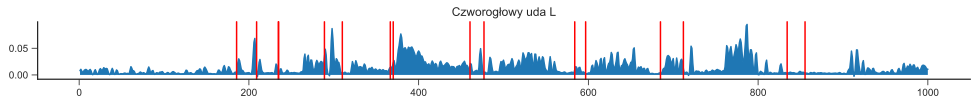

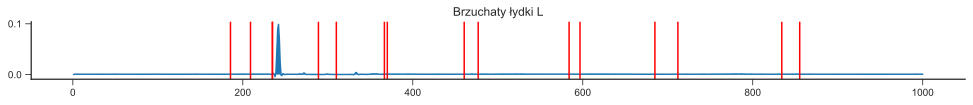

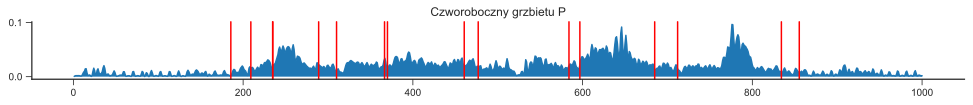

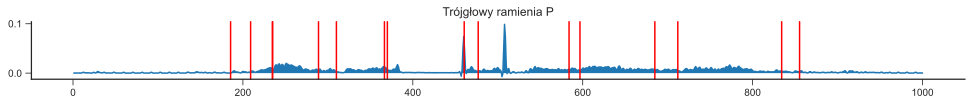

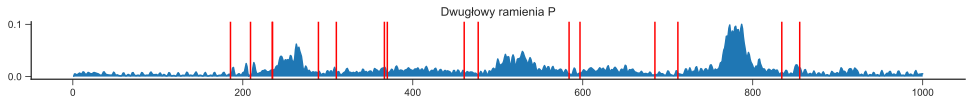

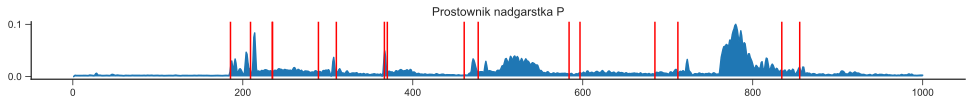

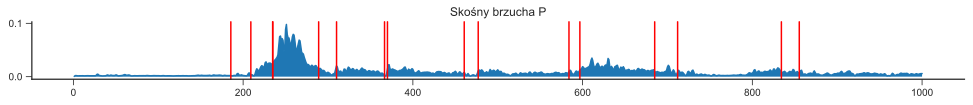

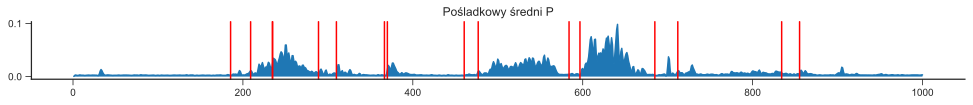

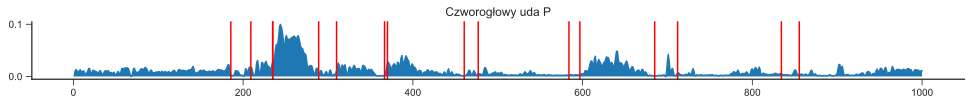

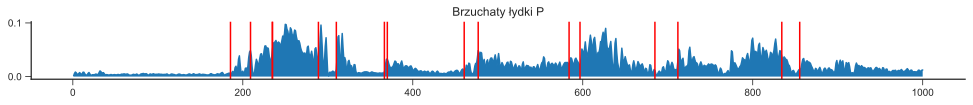

In [201]:
aver_arr=np.zeros((16,1000))
    
for num in range(16):
        subplot(1, 2, 1)
        plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=5, 
                    top=0.3, 
                    wspace=0.25, 
                    hspace=0.35)
        
        emg_processed_event=emg_processed[num]
        emg_processed_event2 = (
        emg_processed_event.meca.normalize(ref=None, scale=1)            
        )
        time_normalized=emg_processed_event2.meca.time_normalize(n_frames=1000)
        
        c3d_to_compare= c3d(data_path)
        event_time = c3d_to_compare['parameters']['EVENT']['TIMES']['value'][1]
        n_frames = c3d_to_compare['parameters']['POINT']['FRAMES']['value'][0]
        nn = n_frames/1000
        markevent = event_time/nn*100
       
        for t in range(1000):
                aver_arr[num][t]=aver_arr[num][t]+time_normalized.values[t]
       
        aver_arr[num]=aver_arr[num]/10
        time=np.linspace(1,1000,1000)
        plt.plot(time,aver_arr[num]) 
        for axl in range(16):
            plt.axvline(markevent[axl], color='r')
        plt.title(muscles_names[num])
        plt.fill_between(time,aver_arr[num])
        plt.show()

#### Czas poszczególnych event'ów

In [220]:
#event_StartAction = event_time[0]
#event_EndAction = event_time[1]
event_StartWyciagniecieDoPacjenta = event_time[2]

event_EndWyciagniecieDoPacjenta = event_time[5]

event_StartUgiecieNogPacjenta = event_time[3]

event_EndUgiecieNogPacjenta = event_time[4]

event_StartUlozeniePrawejRekiPacjenta = event_time[6]

event_EndUlozeniePrawejRekiPacjenta = event_time[7]

event_StartUlozenieLewejRekiPacjenta = event_time[8]

event_EndUlozenieLewejRekiPacjenta = event_time[9]

event_StartPrzewroceniePacjenta = event_time[10]

event_EndPrzewroceniePacjenta = event_time[11]

event_StartOpuszczenieNogPacjenta = event_time[12]

event_EndOpuszczenieNogPacjenta = event_time[13]

event_StartPosadzeniePacjenta = event_time[14]

event_EndPosadzeniePacjenta = event_time[15]

#### Wyświetlanie wybranych event'ów

In [238]:
def plot_one_event(event_time_start, event_time_end):
    aver_arr=np.zeros((16,1000))
    
    for num in range(16):
            subplot(1, 2, 1)
            plt.subplots_adjust(left=0.125,
                        bottom=0.1, 
                        right=5, 
                        top=0.3, 
                        wspace=0.25, 
                        hspace=0.35)
        
            emg_processed_event=emg_processed[num]
            emg_processed_event2 = (
            emg_processed_event.meca.normalize(ref=None, scale=1)            
            )
            time_normalized=emg_processed_event2.meca.time_normalize(n_frames=1000)
        
            c3d_to_compare= c3d(data_path)
            event_time = c3d_to_compare['parameters']['EVENT']['TIMES']['value'][1]
            n_frames = c3d_to_compare['parameters']['POINT']['FRAMES']['value'][0]
            nn = n_frames/1000
            markevent_start = event_time_start/nn*100
            markevent_end = event_time_end/nn*100
       
            for t in range(1000):
                    aver_arr[num][t]=aver_arr[num][t]+time_normalized.values[t]
            
            x_axes_start = markevent_start - 5
            x_axes_end = markevent_end + 5
       
            aver_arr[num]=aver_arr[num]/10
            time_aver=np.linspace(x_axes_start,x_axes_end,1000)
            plt.plot(time_aver,aver_arr[num]) 
            plt.axvline(markevent_start, color='g')
            plt.axvline(markevent_end, color='r')
            plt.title(muscles_names[num])
            #plt.fill_between(time,aver_arr[num])
            plt.show()

#### Wyciągniecie do P

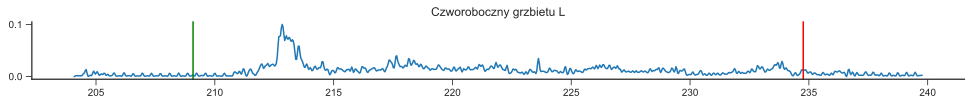

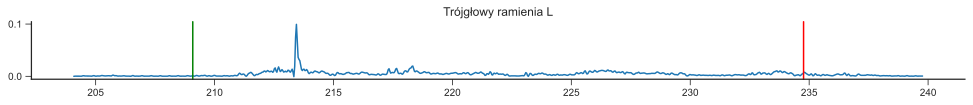

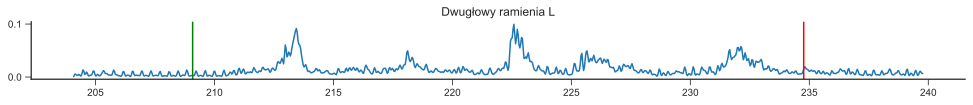

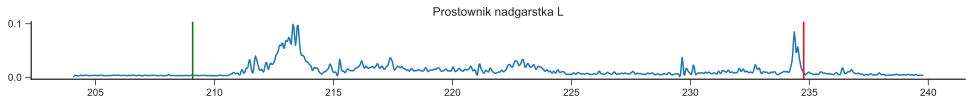

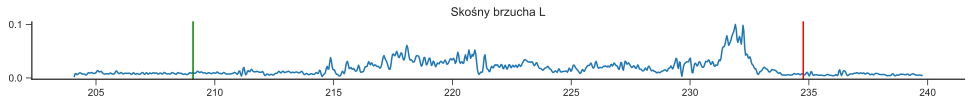

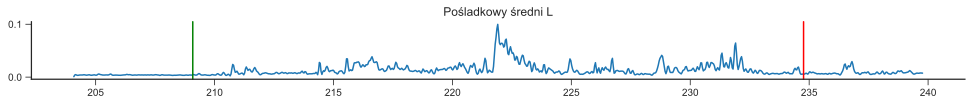

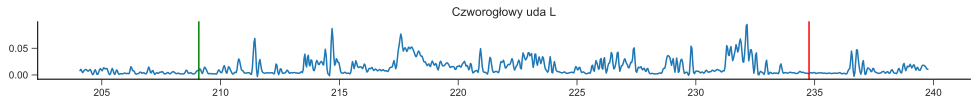

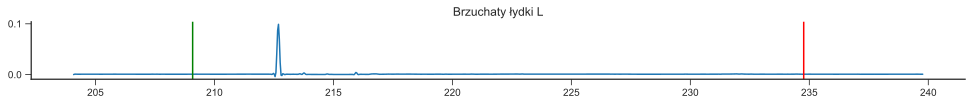

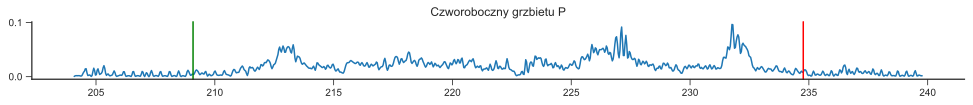

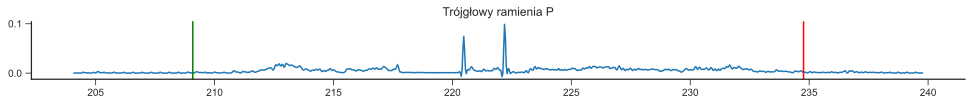

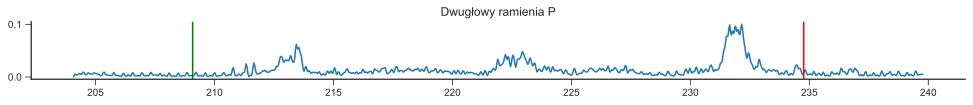

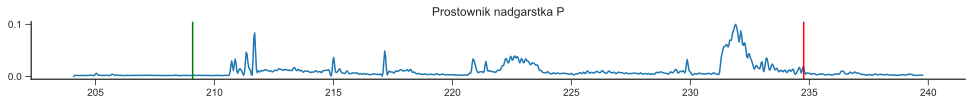

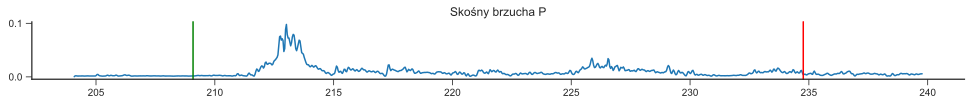

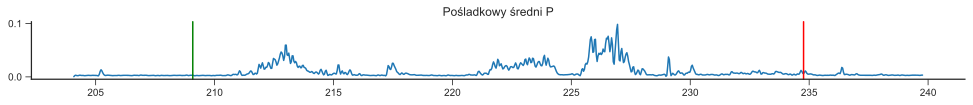

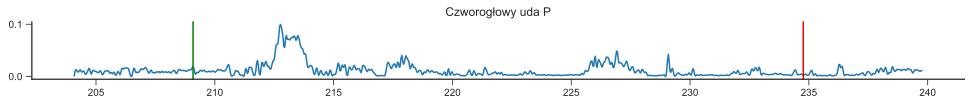

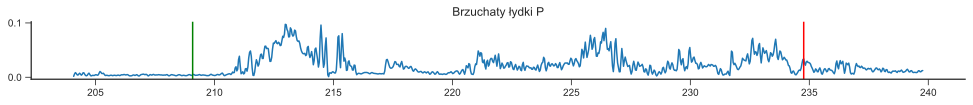

In [239]:
plot_one_event(event_StartWyciagniecieDoPacjenta, event_EndWyciagniecieDoPacjenta)